In [22]:
import gc
keras.backend.clear_session()
#del model1
gc.collect()

284

Matplotlib is building the font cache; this may take a moment.


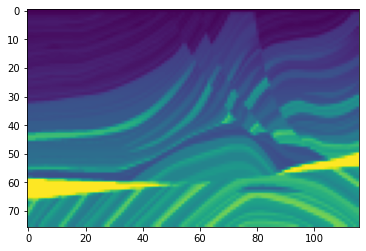

(120, 368)


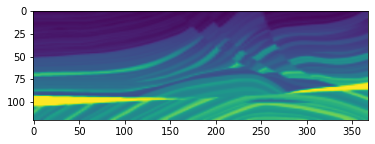

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import interpolate
data = np.loadtxt('mar-vel.dat')
data = np.reshape(data,[data.size])
data = np.transpose(np.reshape(data[:-4],[116,76]))
plt.imshow(data)
plt.show()

X = np.linspace(0,3000,76)
Y = np.linspace(0,9200,116)
f_vmar = interpolate.interp2d(Y,X,data,kind='linear')

Xnew =  np.linspace(0,3000,int(3000/25))
Ynew = np.linspace(0,9200,int(9200/25))
vmar=f_vmar(Ynew,Xnew)
print(vmar.shape)
plt.imshow(vmar)
plt.show()

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras import Input, layers, optimizers
from keras.models import  Model


def ricker(f0,t):
    f=f0
    r=-(np.pi*f*(t-0.1))**2
    return (1+2*r)*(np.e)**r


def kerF(kernel_dimension,var):
    x = np.linspace(-5,5,kernel_dimension)
    k = np.zeros([kernel_dimension,kernel_dimension])
    for ii,i in enumerate(x):
        for jj,j in enumerate(x):
            k[ii,jj] = np.exp(-0.5*((i/var)**2+(j/var)**2))
    k = k/(var*((2*np.pi)**0.5))
    return k

def smoothV(v,kernel_dimension,kerne_variace):
    kernel=kerF(kernel_dimension,kerne_variace)
    kernel=kernel/np.sum(kernel)
    k_smooth=np.zeros(v.shape)
    k_extend=np.pad(v,int((kernel_dimension-1)/2),mode='edge')
    for i in range(nx):
        for j in range(ny):
            k_smooth[i,j]=np.sum(kernel*k_extend[i:i+kernel_dimension,j:j+kernel_dimension])
    return k_smooth


def PML_parameter_gen(nx,ny,npml,dx,vmax,f0):
     
    Xorigin_left= npml*dx #size of PML (meter)
    Yorigin_left= npml*dx
    Xorigin_right=(nx-1)*dx-npml*dx
    Yorigin_right=(ny-1)*dx-npml*dx
    
    ALPHA_MAX_PML=np.pi*f0
    NN=2
    Rc=0.001
    d0_x=-(NN+1)*vmax*np.log(Rc)/(2*Xorigin_left)
#     d0_x=9*vmax/(2*Xorigin_left)

    d_x=np.zeros(nx)
    d_x_half=np.zeros(nx)
    K_x=np.ones(nx)
    K_x_half=np.ones(nx)
    alpha_x=np.zeros(nx)
    alpha_x_half=np.zeros(nx)
    a_x=np.zeros(nx)
    a_x_half=np.zeros(nx)
    b_x=np.zeros(nx)
    b_x_half=np.zeros(nx)
    
    d_y=np.zeros(ny)
    d_y_half=np.zeros(ny)
    K_y=np.ones(ny)
    K_y_half=np.ones(ny)
    alpha_y=np.zeros(ny)
    alpha_y_half=np.zeros(ny)
    a_y=np.zeros(ny)
    a_y_half=np.zeros(ny)
    b_y=np.zeros(ny)
    b_y_half=np.zeros(ny)


    for i in range(nx):
        xval=i*dx

        #Xmin
        absci=Xorigin_left-xval
        if absci >=0 :
            abscissa_normalized=absci/Xorigin_left
            d_x[i]=d0_x*(abscissa_normalized**2)
            alpha_x[i]=ALPHA_MAX_PML*(1-abscissa_normalized)

        absci=Xorigin_left-(xval+dx/2)
        if absci >=0 :
            abscissa_normalized=absci/Xorigin_left
            d_x_half[i]=d0_x*(abscissa_normalized**2)
            alpha_x_half[i]=ALPHA_MAX_PML*(1-abscissa_normalized)


        #Xmax
        absci=xval-Xorigin_right
        if absci >=0 :
            abscissa_normalized=absci/Xorigin_left
            d_x[i]=d0_x*(abscissa_normalized**2)
            alpha_x[i]=ALPHA_MAX_PML*(1-abscissa_normalized)

        absci=xval+dx/2-Xorigin_right
        if absci >=0 :
            abscissa_normalized=absci/Xorigin_left
            d_x_half[i]=d0_x*(abscissa_normalized**2)
            alpha_x_half[i]=ALPHA_MAX_PML*(1-abscissa_normalized)


        b_x[i] = np.exp(- (d_x[i]  + alpha_x[i]) * dt)
        b_x_half[i] = np.exp(- (d_x_half[i]  + alpha_x_half[i]) * dt)

        if abs(d_x[i]) >1e-6 :
            a_x[i] = d_x[i] * (b_x[i] - 1) / (K_x[i] * (d_x[i] + K_x[i] * alpha_x[i]))

        if abs(d_x_half[i]) > 1e-6: 
            a_x_half[i] = d_x_half[i] * (b_x_half[i] - 1) / (K_x_half[i] * (d_x_half[i] + K_x_half[i] * alpha_x_half[i]))
    
    for i in range(ny):
        xval=i*dx

        #Ymin
        absci=Yorigin_left-xval
        if absci >=0 :
            abscissa_normalized=absci/Yorigin_left
            d_y[i]=d0_x*(abscissa_normalized**2)
            alpha_y[i]=ALPHA_MAX_PML*(1-abscissa_normalized)

        absci=Yorigin_left-(xval+dx/2)
        if absci >=0 :
            abscissa_normalized=absci/Yorigin_left
            d_y_half[i]=d0_x*(abscissa_normalized**2)
            alpha_y_half[i]=ALPHA_MAX_PML*(1-abscissa_normalized)


        #Ymax
        absci=xval-Yorigin_right
        if absci >=0 :
            abscissa_normalized=absci/Yorigin_left
            d_y[i]=d0_x*(abscissa_normalized**2)
            alpha_y[i]=ALPHA_MAX_PML*(1-abscissa_normalized)

        absci=xval+dx/2-Yorigin_right
        if absci >=0 :
            abscissa_normalized=absci/Yorigin_left
            d_y_half[i]=d0_x*(abscissa_normalized**2)
            alpha_y_half[i]=ALPHA_MAX_PML*(1-abscissa_normalized)


        b_y[i] = np.exp(- (d_y[i]  + alpha_y[i]) * dt)
        b_y_half[i] = np.exp(- (d_y_half[i]  + alpha_y_half[i]) * dt)

        if abs(d_y[i]) >1e-6 :
            a_y[i] = d_y[i] * (b_y[i] - 1) / (K_y[i] * (d_y[i] + K_y[i] * alpha_y[i]))

        if abs(d_y_half[i]) > 1e-6: 
            a_y_half[i] = d_y_half[i] * (b_y_half[i] - 1) / (K_y_half[i] * (d_y_half[i] + K_y_half[i] * alpha_y_half[i]))
            
    return a_x,b_x,a_x_half,b_x_half,a_y,b_y,a_y_half,b_y_half



## model
def customRelu1(x):
    x=keras.activations.relu(x,alpha=0.0, max_value=0.6, threshold=0.0)
    return x

def MLapace(u1,mpx,mpxx,mpy,mpyy):
        vpx = DxRlayers(u1)
        mpx1 = Mtlayers(input_bhx,mpx)
        mpx2 = Mtlayers(input_ahx,vpx)
        mpx = Alayers([mpx1,mpx2])
        pxx = Alayers([vpx,mpx])

        vpxx = DxLlayers(pxx)
        mpxx1 = Mtlayers(input_bx,mpxx)
        mpxx2 = Mtlayers(input_ax,vpxx)
        mpxx = Alayers([mpxx1,mpxx2])
        pxx = Alayers([vpxx,mpxx])
        
        vpy = DyRlayers(u1)
        mpy1 = Mlayers([input_bhy,mpy])
        mpy2 = Mlayers([input_ahy,vpy])
        mpy = Alayers([mpy1,mpy2])
        pyy = Alayers([vpy,mpy])

        vpyy = DyLlayers(pyy)
        mpyy1 = Mlayers([input_by,mpyy])
        mpyy2 = Mlayers([input_ay,vpyy])
        mpyy = Alayers([mpyy1,mpyy2])
        pyy = Alayers([vpyy,mpyy])
    
        return pxx,pyy,mpx,mpxx,mpy,mpyy

def wave(u0,u1,pxx,pyy,velocitylocal,source):
        x =Alayers([pxx,pyy])
        x = Mlayers([x,velocitylocal])
        uu1= Alayers([u1,u1])
        x = Alayers([x,uu1])
        u2 = Slayers([x,u0])    
        u2 = Slayers([u2,source])    
        u2 = MulBClayer(u2)
        return u1,u2 

def read(trace,s,u1,timeskip,i):
        if i%timeskip==0 :
            value = receiversLayer2(u1)
            trace = C2layers([trace,value])     
            
        sourcei = Pickfunction(s)
        source = MSlayers([sourcei,input_sp])
        s=CropS(s)     
        return trace,s,source
    
def repeat1(x):
    return keras.backend.repeat_elements(x,rep=npml, axis=1)
def repeat2(x):
    return keras.backend.repeat_elements(x,rep=npml, axis=2)

def PML_pad(x):
    xl0=PML_PickT(x)
    xr0=PML_PickB(x)
    xl=PML_repeat1(xl0)
    xr=PML_repeat1(xr0)
    x1=C1layers([xl,x,xr]) 
    xt0=PML_PickL(x1)
    xb0=PML_PickR(x1)
    xt=PML_repeat2(xt0)
    xb=PML_repeat2(xb0)
    return C2layers([xt,x1,xb])

def Mtlayers(x1,x2):
    x2t=PerM(x2)
    x=Mlayers([x2t,x1])
    return PerM(x)

def timesquare(x):
    T=tf.constant(time_2.astype(np.float32))
    return x*T

def MulSourceF(x):
    y=tf.multiply(x[0],tf.reshape(x[1], [-1,nx*ny]))
    return  tf.reshape(y, [-1,nx,ny,1])

def Cell(trace,velocitylocal,stotal,u0,u1,mpx,mpxx,mpy,mpyy,NT):
    for i in range(1,NT):
        [trace,stotal,source]=read(trace,stotal,u1,timeskip,i)
        [pxx,pyy,mpx,mpxx,mpy,mpyy] = MLapace(u1,mpx,mpxx,mpy,mpyy)             
        [u0,u1] = wave(u0,u1,pxx,pyy,velocitylocal,source)  
    return trace


    
def MulBCF(x): 
    return tf.multiply(x,tfconstantsBC)


 #layer
MulBClayer = layers.Lambda(MulBCF,trainable=False,name="Mul0")
receiversLayer2= layers.Lambda(lambda x: x[:,Rp[0],Rp[1]:Rp[2]:Rp[3],0:],trainable=False,name='Recievers') 
DxLlayers=layers.Conv2D(1,(3,1),padding='same', activation=None,use_bias=False,trainable=False,name='DxL')
DxRlayers=layers.Conv2D(1,(3,1),padding='same', activation=None,use_bias=False,trainable=False,name='DxR')
DyLlayers=layers.Conv2D(1,(1,3),padding='same', activation=None,use_bias=False,trainable=False,name='DyL')
DyRlayers=layers.Conv2D(1,(1,3),padding='same', activation=None,use_bias=False,trainable=False,name='DyR')   

I = layers.Lambda(lambda x: x,name='Identity',trainable=False)
Alayers = layers.Add(name='Add',trainable=False)
Mlayers = layers.Multiply(name='Multiply',trainable=False)
Slayers = layers.Subtract(name='Subtract',trainable=False)
C1layers = layers.Concatenate(axis=1,name='Concate1',trainable=False)
C2layers = layers.Concatenate(axis=2,name='Concate2',trainable=False)
CropS=layers.Lambda(lambda x: x[:,1:],name="Crop_source",trainable=False)
Pickfunction = layers.Lambda(lambda x: x[:,0],name="Pick_source",trainable=False)
MSlayers= layers.Lambda(MulSourceF,trainable=False,name="MulSource")
PerM=layers.Permute(dims=(2,1,3),trainable=False,name="Permute")
Upsamplinglayer= layers.UpSampling2D(size=(2, 2),name='upsampling')
#T2layer = layers.Lambda(timesquare,name='T2layer',trainable=False)

#PML layers
Padding = layers.Lambda(PML_pad,trainable=False,name="padding")
PML_PickT = layers.Lambda(lambda x: x[:,0:1,:,0:],trainable=False,name="T") 
PML_PickB = layers.Lambda(lambda x: x[:,-1:,:,0:],trainable=False,name="B")
PML_PickL = layers.Lambda(lambda x: x[:,:,0:1,0:],trainable=False,name="L") 
PML_PickR = layers.Lambda(lambda x: x[:,:,-1:,0:],trainable=False,name="R")
PML_repeat1 = layers.Lambda(repeat1,trainable=False,name="repeat1")
PML_repeat2 = layers.Lambda(repeat2,trainable=False,name="repeat2")




def create_network(nx,ny,nt,dx,dt,timeskip):  
    
    global input_sp,input_ax,input_bx,input_ahx,input_bhx,input_ay,input_by,input_ahy,input_bhy
            
    input_s = Input(shape=(nt,1),name="Input_source") # source
    input_sp = Input(shape=(nx,ny),name="Input_source_position")
    
    fixed_input0 = Input(shape=(nx,ny,1))
    #constants =  np.zeros([1,nx,ny,1],dtype=np.float32)
    #fixed_input0 = Input(shape=(nx,ny,1),tensor=tf.constant(constants))
    #constants =  time_2.astype(np.float32)
    #fixed_T2 = Input(shape=(time_2.shape),tensor=tf.constant(constants))
    constants =  a_x.astype(np.float32).reshape(nx,1)
    input_ax = Input(shape=(nx,1),tensor=tf.constant(constants))
    constants =  b_x.astype(np.float32).reshape(nx,1)
    input_bx = Input(shape=(nx,1),tensor=tf.constant(constants))
    constants =  a_x_half.astype(np.float32).reshape(nx,1)
    input_ahx =Input(shape=(nx,1),tensor=tf.constant(constants))
    constants =  b_x_half.astype(np.float32).reshape(nx,1)
    input_bhx =Input(shape=(nx,1),tensor=tf.constant(constants))   
    
    constants =  a_y.astype(np.float32).reshape(ny,1)
    input_ay = Input(shape=(ny,1),tensor=tf.constant(constants))
    constants =  b_y.astype(np.float32).reshape(ny,1)
    input_by = Input(shape=(ny,1),tensor=tf.constant(constants))
    constants =  a_y_half.astype(np.float32).reshape(ny,1)
    input_ahy =Input(shape=(ny,1),tensor=tf.constant(constants))
    constants =  b_y_half.astype(np.float32).reshape(ny,1)
    input_bhy =Input(shape=(ny,1),tensor=tf.constant(constants))   
    
    Local=layers.Dense((nx-2*npml)*(ny-2*npml),activation=customRelu1,use_bias=False,name='local_velocity')

    constants= np.ones(1)*dt/dx
    constants=constants.astype(np.float32).reshape(1,1)
    input_c = Input(shape=(1,),tensor=tf.constant(constants)) 
    
    
    
    # initial 
    velocitylocal = Local(input_c)
    velocitylocal =  layers.Reshape([nx-2*npml,ny-2*npml,1],trainable=False,name='reshape_V')(velocitylocal)
    velocitylocal = Padding(velocitylocal)
    velocitylocal = Mlayers([velocitylocal,velocitylocal])

    #Initialize 
    u0 = I(fixed_input0)
    mpx=I(fixed_input0)
    mpxx=I(fixed_input0)
    mpy=I(fixed_input0)
    mpyy=I(fixed_input0)
    
    trace = receiversLayer2(u0)
    sourcei = Pickfunction(input_s)
    source = MSlayers([sourcei,input_sp])
    u1 = Alayers([u0,source]) 
    u1 = MulBClayer(u1)
    stotal = CropS(input_s)
    
    trace = Cell(trace,velocitylocal,stotal,u0,u1,mpx,mpxx,mpy,mpyy,nt)
    #Y = T2layer(trace)
    
    model = Model([input_s,input_sp,fixed_input0,input_c,input_ax,input_bx,input_ahx,input_bhx,input_ay,input_by,input_ahy,input_bhy], trace)
    return model



Using TensorFlow backend.


In [3]:
def velocity_profile(nx,ny,pmlsize):
    layer=[500,1500,2000,2500]  #  position of boundary [meter] 
    velocity=[2000,2500,3000,4000,5000] # m/s  
        
    layer=np.array(layer)+pmlsize
    v=np.zeros([nx,ny])
    k0=0
    for j,i in enumerate(layer):
        k1=int(i/dx)
        v[k0:k1,:]=velocity[j]
        k0=k1
        
    v[k0:,:]=velocity[j+1]  
    return v

def Mulx(a,b):
    return np.transpose(np.transpose(a)*b)

def data_gen(nt,nx,ny,dx,dt,f0,rp,source,timeskip,v,a_x,b_x,a_x_half,b_x_half,a_y,b_y,a_y_half,b_y_half):
    YY=np.empty(0)    
    for sp in source:  
        Y=[]  #wave at reciever
        So=np.zeros([nt]) #source
        Rp=((np.array(rp)+[PMLsize,PMLsize])/dx).astype(int)
        sp=np.array(sp)+PMLsize 
        Sp=np.zeros([nx,ny])
        Sp[int(sp[0]/dx),int(sp[1]/dx)]=1


        mpx=np.zeros([nx,ny])
        mpxx=np.zeros([nx,ny])
        vpx=np.zeros([nx,ny])
        vpxx=np.zeros([nx,ny])
        pxx=np.zeros([nx,ny])
        dpxx=np.zeros([nx,ny])

        mpy=np.zeros([nx,ny])
        mpyy=np.zeros([nx,ny])
        vpy=np.zeros([nx,ny])
        vpyy=np.zeros([nx,ny])
        pyy=np.zeros([nx,ny])
        dpyy=np.zeros([nx,ny])    

        u0=np.zeros([nx,ny])
        u1=np.zeros([nx,ny])
        u2=np.zeros([nx,ny])


        kappa=(v**2)*dt*dt/dx/dx

        vsource=kappa[int(sp[0]/dx),int(sp[1]/dx)]*dx*dx
        
        for it in range(nt):

            So[it]=ricker(f0,it*dt)*vsource

            if it%timeskip==0:
                Y=np.append(Y,[u1[i,j] for i,j in Rp])
                #plt.imshow(u1, vmin=-10, vmax=10)
                #plt.show()

            vpx[:-1,:]=(u1[1:,:]-u1[:-1,:])
            mpx = Mulx(mpx,b_x_half)+Mulx(vpx,a_x_half)
            pxx= vpx+mpx

            vpxx[1:,:]= (pxx[1:,:]-pxx[:-1,:])
            mpxx = Mulx(mpxx,b_x)+Mulx(vpxx,a_x)
            dpxx= vpxx+mpxx


            vpy[:,:-1]=(u1[:,1:]-u1[:,:-1])
            mpy = b_y_half*mpy+a_y_half*vpy
            pyy= vpy+mpy

            vpyy[:,1:]= (pyy[:,1:]-pyy[:,:-1])
            mpyy = b_y*mpyy+a_y*vpyy 
            dpyy= vpyy+mpyy

            u2=2*u1-u0+kappa*(dpxx+dpyy)-Sp*So[it]
            u2[:,0]=0
            u2[:,-1]=0
            u2[0,:]=0
            u2[-1,:]=0   

            u0[:,:]=u1[:,:]
            u1[:,:]=u2[:,:] 

        Y=np.transpose(Y.reshape([int(Y.size/len(rp)),int(len(rp))]))  
        #time_2=np.arange(0,totaltime,dt*timeskip)
        #time_2=time_2**2
        #Y=Y*time_2
        
        Y = np.expand_dims(Y, axis=0)
        Sp= np.expand_dims(Sp, axis=0)
        So= np.expand_dims(So, axis=0)
        
        if YY.size==0:
            YY=np.array(Y)
            XSp=np.array(Sp)
            XSo=np.array(So)
        else:   
            YY=np.append(YY,Y,axis=0)     
            XSp=np.append(XSp,Sp,axis=0)
            XSo=np.append(XSo,So,axis=0)
            
    #YY = np.expand_dims(YY, axis=3)
    #XSp= np.expand_dims(XSp, axis=3)   
    XSo= np.expand_dims(XSo, axis=2)   
    return YY,XSp,XSo


(120, 368)
(130, 378)
number of sources  12
data sampling  449
number of receivers  368


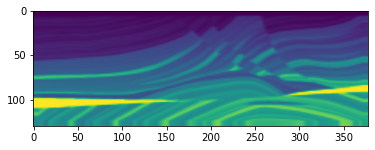

In [23]:
f0=12
totaltime=3.5
DimensionX=3000
DimensionY=9200
dx=25
PMLsize=dx*5
receiver_depth=50
receiver_first=0
receiver_last=DimensionY
receiver_space=dx

#sp=np.array([[100,j] for j in np.arange(100,9200-100,700)])
sp=np.array([[100,j] for j in np.arange(100,9100,750)])
timeskip=3

rp=np.array([[receiver_depth,i] for i in np.arange(receiver_first,receiver_last,receiver_space)])
nx=int((DimensionX+2*PMLsize)/dx)
ny=int((DimensionY+2*PMLsize)/dx)
npml= int(PMLsize/dx)


#velocity = velocity_profile(nx,ny,PMLsize) 

Xnew =  np.linspace(0,3000,int(3000/dx))
Ynew = np.linspace(0,9200,int(9200/dx))
velocity =f_vmar(Ynew,Xnew)
print(velocity.shape)
velocity=np.pad(velocity, (npml, npml), 'edge')
print(velocity.shape)


vmax=np.max(velocity)*1.05
dt=0.6*dx/vmax
nt=int(totaltime/dt)    
[a_x,b_x,a_x_half,b_x_half,a_y,b_y,a_y_half,b_y_half] = PML_parameter_gen(nx,ny,npml,dx,vmax,f0)
[Y,Xsp,Xs]=data_gen(nt,nx,ny,dx,dt,f0,rp,sp,timeskip,velocity,a_x,b_x,a_x_half,b_x_half,a_y,b_y,a_y_half,b_y_half)


# parameter for model
constantsBC=np.ones([nx,ny,1])
constantsBC[0,:,0]=0 
constantsBC[-1,:,0]=0
constantsBC[:,0,0]=0 
constantsBC[:,-1,0]=0
tfconstantsBC=tf.constant(constantsBC.astype(np.float32))

X_initial=np.zeros([sp.shape[0],nx,ny,1])

#time_2=np.arange(0,totaltime,dt*timeskip)
#time_2=time_2**2
Rp=((np.array([receiver_depth+PMLsize,receiver_first+PMLsize,receiver_last+PMLsize,receiver_space])/dx).astype(int))     
 
#dispaly
print('number of sources ', Y.shape[0])
print('data sampling ', Y.shape[2])
print('number of receivers ', Y.shape[1])
plt.imshow(velocity)
#circle1=plt.Circle((int((sp[1]+PMLsize)/dx),int((sp[0]+PMLsize)/dx)),2,color='r')
#plt.gcf().gca().add_artist(circle1)
plt.show()

In [ ]:
Y.shape[0]

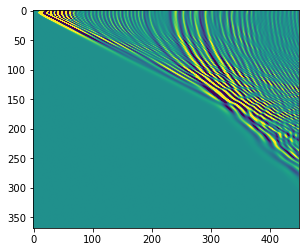

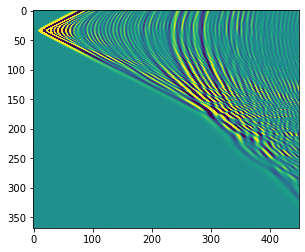

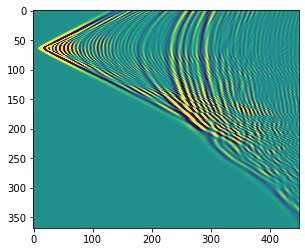

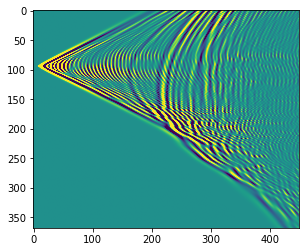

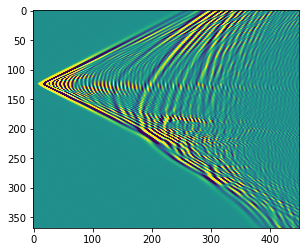

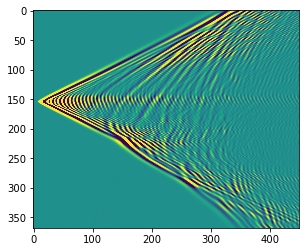

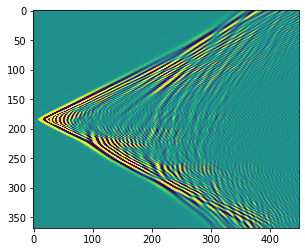

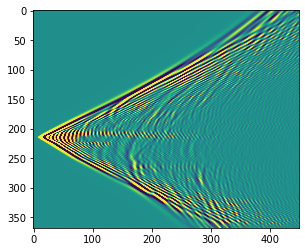

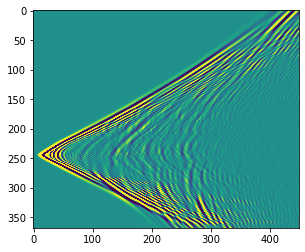

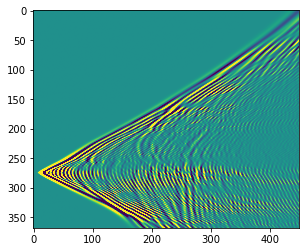

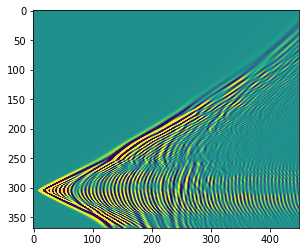

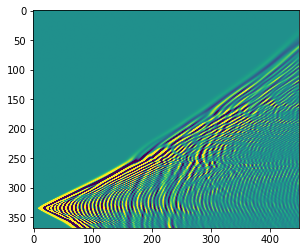

In [24]:
for i in range(Y.shape[0]):
    plt.imshow(Y[i,], vmin=-2, vmax=2)
    plt.show()

In [ ]:
np.max(velocity)

In [25]:
model1=create_network(nx,ny,nt,dx,dt,timeskip)

numlayer={}
for i,l in enumerate(model1.layers):
    numlayer[l.name] = i
    print(i,l.name, l.trainable) 
    
WL=np.array([-1,1,0])
WR=np.array([0,-1,1])
       
#set initial new velocity profile
a=np.array(model1.layers[numlayer['local_velocity']].get_weights()).shape
#model1.layers[numlayer['local_velocity']].set_weights(v_smooth[npml:-npml,npml:-npml].reshape(a))
model1.layers[numlayer['local_velocity']].set_weights(velocity[npml:-npml,npml:-npml].reshape(a))

a=np.array(model1.layers[numlayer['DxR']].get_weights()).shape
model1.layers[numlayer['DxR']].set_weights(WR.reshape(a))

a=np.array(model1.layers[numlayer['DxL']].get_weights()).shape
model1.layers[numlayer['DxL']].set_weights(WL.reshape(a))

a=np.array(model1.layers[numlayer['DyR']].get_weights()).shape
model1.layers[numlayer['DyR']].set_weights(WR.reshape(a))

a=np.array(model1.layers[numlayer['DyL']].get_weights()).shape
model1.layers[numlayer['DyL']].set_weights(WL.reshape(a))


0 Input_source False
1 input_1 False
2 Pick_source False
3 Input_source_position False
4 Identity False
5 MulSource False
6 Add False
7 Mul0 False
8 Permute False
9 input_5 False
10 Multiply False
11 DxR False
12 input_4 False
13 input_3 False
14 DxL False
15 input_2 False
16 DyR False
17 input_9 False
18 input_8 False
19 DyL False
20 input_7 False
21 input_6 False
22 input_10 False
23 local_velocity True
24 reshape_V False
25 padding False
26 Crop_source False
27 Subtract False
28 Recievers False
29 Concate2 False


In [ ]:
model1.compile(optimizer=tf.optimizers.Adam(lr=40), loss='mse') 
model1.evaluate(x=[Xs,Xsp,X_initial],y=Y)  

In [ ]:
item=10

#Ypredict=model1.predict([Xs[item:item+1,],Xsp[item:item+1,],X_initial[item:item+1,]])
Ypredict=model1.predict([Xs[item:item+1,],Xsp[item:item+1,]])
YY=Ypredict.reshape([Y.shape[1],Y.shape[2]])
plt.imshow(YY, vmin=-2, vmax=2)
plt.show()
plt.imshow(Y[item,], vmin=-2, vmax=2)
plt.show()
plt.imshow(Y[item,]-YY, vmin=-2, vmax=2)
plt.show()
print(np.sum(abs(Y[item,]-YY))/YY.size)

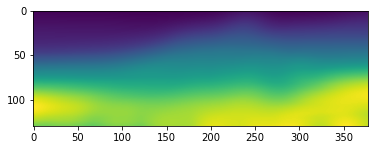

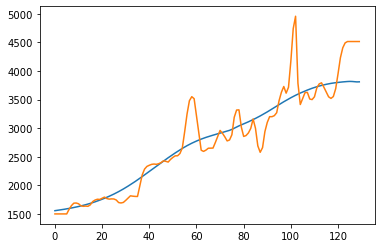

In [26]:
#create smooth initial velocity profile 
kernel_dimension=int((50) +1) # dimension of smooth function
kerne_variace=2.8 # width of smooth function
v_smooth=smoothV(velocity,kernel_dimension,kerne_variace)

plt.imshow(v_smooth)
plt.show()
plt.plot(v_smooth[:,150])
plt.plot(velocity[:,150])
plt.show()

In [ ]:
#test smooth initial velocity profile 
def kerF(kernel_dimension,var):
    x = np.linspace(-5,5,kernel_dimension)
    k = np.zeros([kernel_dimension,kernel_dimension])
    for ii,i in enumerate(x):
        for jj,j in enumerate(x):
            k[ii,jj] = np.exp(-0.5*((i/var)**2+(j/var)**2))
    k = k/(var*((2*np.pi)**0.5))
    return k

def smoothV(v,kernel_dimension,kerne_variace):
    kernel=kerF(kernel_dimension,kerne_variace)
    kernel=kernel/np.sum(kernel)
    k_smooth=np.zeros(v.shape)
    k_extend=np.pad(v,int((kernel_dimension-1)/2),mode='edge')
    for i in range(nx):
        for j in range(ny):
            k_smooth[i,j]=np.sum(kernel*k_extend[i:i+kernel_dimension,j:j+kernel_dimension])
    return k_smooth


dx=20
DimensionX=3000
DimensionY=9200
PMLsize=200
npml= int(PMLsize/dx)
nx=int((DimensionX+2*PMLsize)/dx)
ny=int((DimensionY+2*PMLsize)/dx)

Xnew =  np.linspace(0,DimensionX,int(DimensionX/dx))
Ynew = np.linspace(0,DimensionY,int(DimensionY/dx))
velocity =f_vmar(Ynew,Xnew)
velocity=np.pad(velocity, (npml, npml), 'edge')

kernel_dimension=int((50) +1) # dimension of smooth function
kerne_variace=2.8 # width of smooth function
v_smooth=smoothV(velocity,kernel_dimension,kerne_variace)

plt.imshow(v_smooth)
plt.show()
plt.plot(v_smooth[:,150])
plt.plot(velocity[:,150])
plt.show()

In [27]:
a=np.array(model1.layers[numlayer['local_velocity']].get_weights()).shape
model1.layers[numlayer['local_velocity']].set_weights(v_smooth[npml:-npml,npml:-npml].reshape(a))

In [ ]:
#set initial new velocity profile
a=np.array(model1.layers[numlayer['local_velocity']].get_weights()).shape
#model1.layers[numlayer['local_velocity']].set_weights(v_smooth[npml:-npml,npml:-npml].reshape(a))
model1.layers[numlayer['local_velocity']].set_weights(velocity[npml:-npml,npml:-npml].reshape(a))

In [28]:
model1.compile(optimizer=tf.optimizers.Adam(lr=40), loss='mse') 

In [33]:
history=model1.fit(x=[Xs,Xsp,X_initial],y=Y,epochs=400,verbose=1,batch_size=6,shuffle=True)  

Epoch 1/400
12/12 [==============================] - 11s 898ms/step - loss: 0.6120
Epoch 2/400
12/12 [==============================] - 11s 893ms/step - loss: 0.6038
Epoch 3/400
12/12 [==============================] - 11s 892ms/step - loss: 0.5852
Epoch 4/400
12/12 [==============================] - 11s 896ms/step - loss: 0.5614
Epoch 5/400
12/12 [==============================] - 11s 895ms/step - loss: 0.5602
Epoch 6/400
12/12 [==============================] - 11s 896ms/step - loss: 0.5373
Epoch 7/400
12/12 [==============================] - 11s 899ms/step - loss: 0.5527
Epoch 8/400
12/12 [==============================] - 11s 899ms/step - loss: 0.5370
Epoch 9/400
12/12 [==============================] - 11s 899ms/step - loss: 0.5228
Epoch 10/400
12/12 [==============================] - 11s 900ms/step - loss: 0.5361
Epoch 11/400
12/12 [==============================] - 11s 898ms/step - loss: 0.5243
Epoch 12/400
12/12 [==============================] - 11s 899ms/step - loss: 0.5343
E

12/12 [==============================] - 11s 901ms/step - loss: 0.4186
Epoch 99/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4205
Epoch 100/400
12/12 [==============================] - 11s 898ms/step - loss: 0.4198
Epoch 101/400
12/12 [==============================] - 11s 900ms/step - loss: 0.4168
Epoch 102/400
12/12 [==============================] - 11s 898ms/step - loss: 0.4224
Epoch 103/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4187
Epoch 104/400
12/12 [==============================] - 11s 900ms/step - loss: 0.4620
Epoch 105/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4728
Epoch 106/400
12/12 [==============================] - 11s 898ms/step - loss: 0.4339
Epoch 107/400
12/12 [==============================] - 11s 898ms/step - loss: 0.4475
Epoch 108/400
12/12 [==============================] - 11s 900ms/step - loss: 0.4581
Epoch 109/400
12/12 [==============================] - 11s 899ms/step - loss: 0.

12/12 [==============================] - 11s 899ms/step - loss: 0.4850
Epoch 195/400
12/12 [==============================] - 11s 900ms/step - loss: 0.4901
Epoch 196/400
12/12 [==============================] - 11s 898ms/step - loss: 0.4809
Epoch 197/400
12/12 [==============================] - 11s 901ms/step - loss: 0.4464
Epoch 198/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4777
Epoch 199/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4580
Epoch 200/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4249
Epoch 201/400
12/12 [==============================] - 11s 899ms/step - loss: 0.4688
Epoch 202/400
12/12 [==============================] - 11s 901ms/step - loss: 0.5015
Epoch 203/400
12/12 [==============================] - 11s 901ms/step - loss: 0.4940
Epoch 204/400
12/12 [==============================] - 11s 899ms/step - loss: 0.5222
Epoch 205/400
12/12 [==============================] - 11s 900ms/step - loss: 0

12/12 [==============================] - 10s 874ms/step - loss: 0.4946
Epoch 291/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5410
Epoch 292/400
12/12 [==============================] - 10s 874ms/step - loss: 0.4800
Epoch 293/400
12/12 [==============================] - 10s 875ms/step - loss: 0.5451
Epoch 294/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5383
Epoch 295/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5359
Epoch 296/400
12/12 [==============================] - 10s 875ms/step - loss: 0.5514
Epoch 297/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5005
Epoch 298/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5350
Epoch 299/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5046
Epoch 300/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5651
Epoch 301/400
12/12 [==============================] - 11s 875ms/step - loss: 0

12/12 [==============================] - 10s 874ms/step - loss: 0.4439
Epoch 387/400
12/12 [==============================] - 10s 873ms/step - loss: 0.5699
Epoch 388/400
12/12 [==============================] - 10s 872ms/step - loss: 0.5045
Epoch 389/400
12/12 [==============================] - 10s 873ms/step - loss: 0.4828
Epoch 390/400
12/12 [==============================] - 10s 875ms/step - loss: 0.4967
Epoch 391/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5863
Epoch 392/400
12/12 [==============================] - 10s 874ms/step - loss: 0.4637
Epoch 393/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5069
Epoch 394/400
12/12 [==============================] - 10s 874ms/step - loss: 0.4426
Epoch 395/400
12/12 [==============================] - 10s 874ms/step - loss: 0.5070
Epoch 396/400
12/12 [==============================] - 10s 874ms/step - loss: 0.4616
Epoch 397/400
12/12 [==============================] - 10s 874ms/step - loss: 0

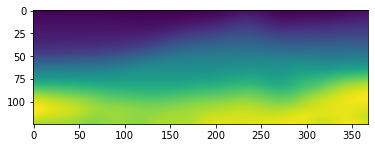

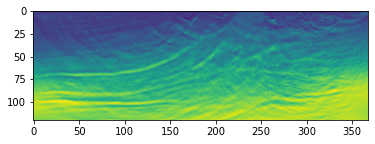

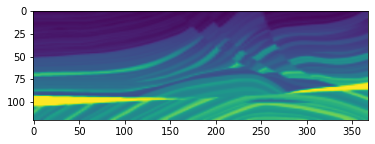

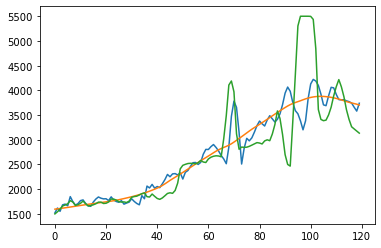

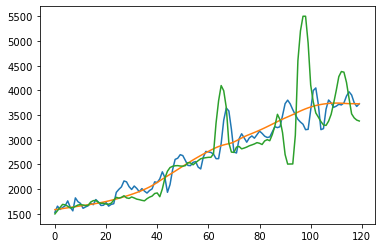

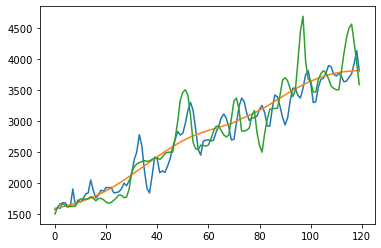

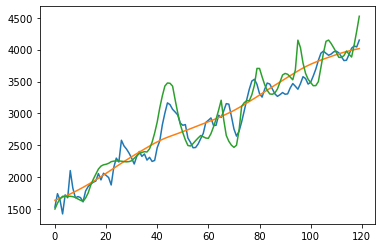

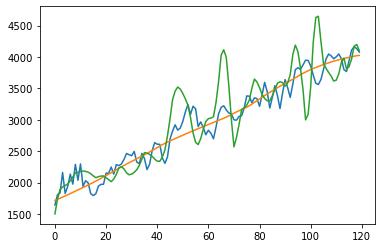

In [32]:
a=np.array(model1.layers[numlayer['local_velocity']].get_weights())
a=a.reshape([nx-2*npml,ny-2*npml])
plt.imshow(v_smooth[:-npml,npml:-npml])
plt.show()
plt.imshow(a)
plt.show()
plt.imshow(velocity[npml:-npml,npml:-npml])
plt.show()

for i in range(5):
    position_Y=i*50+50
    #position_Y=int(position_Y/dx+npml)
    plt.plot(a[:,position_Y])
    plt.plot(v_smooth[npml:-npml,position_Y+npml])
    plt.plot(velocity[npml:-npml,position_Y+npml])
    plt.show()
#     plt.plot(a[:,position_Y]-velocity[npml:-npml,position_Y])
#     plt.show()

In [ ]:
npml

In [ ]:
x1=np.arange(1,21)
print(x1)
x2=np.random.randint(1,5,[2,3,4])
print(x2[0,:,:])
print(x2[1,:,:])
y1=model.predict([x1.reshape([2,10,1]),x2])
print(y1.shape)
print(y1.reshape(x2.shape)[0,])
print(y1.reshape(x2.shape)[1,])